In [1]:
# --------------------------
# 1. 필요한 라이브러리 설치
# --------------------------


print("🚀 라이브러리 설치 시작!")
!pip install yfinance pandas matplotlib duckdb streamlit fredapi pyngrok requests --quiet
print("✅ 라이브러리 설치 완료!")

🚀 라이브러리 설치 시작!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00
✅ 라이브러리 설치 완료!


In [2]:
# --------------------------
# 2. 데이터 수집
# --------------------------

print("\n🚀 데이터 수집 시작!")

import requests
import pandas as pd
import duckdb
import datetime
import matplotlib.pyplot as plt
import os
import threading
import time
from pyngrok import ngrok
import yfinance as yf

# DuckDB 연결
con = duckdb.connect(database='buffett_indicator.duckdb', read_only=False)

# ✅ 2-1. Fear & Greed Index 수집
print("🔍 Fear & Greed Index API 호출 중...")
url = 'https://api.alternative.me/fng/?limit=0&format=json&date_format=us'
response = requests.get(url)
data = response.json()
print("✅ API 데이터 수신 완료!")

fng_data = pd.DataFrame(data['data'])
print(f"📊 원본 데이터 행 수: {len(fng_data)}")
columns={'timestamp': 'Date',
         'value': 'FearGreedValue',
         'value_classification': 'Classification'}
fng_data['timestamp'] = pd.to_datetime(fng_data['timestamp'])
fng_data = fng_data.rename(columns=columns)
fng_data['FearGreedValue'] = fng_data['FearGreedValue'].astype(int)
fng_data = fng_data[['Date', 'FearGreedValue', 'Classification']]
fng_data = fng_data.sort_values('Date')

print("📦 Fear & Greed Index 데이터 DuckDB 저장 중...")
con.execute("CREATE OR REPLACE TABLE fear_greed_index_data AS SELECT * FROM fng_data")
print("✅ 저장 완료! Fear & Greed Index 데이터 미리보기:")
print(con.execute("SELECT * FROM fear_greed_index_data LIMIT 5").fetchdf())

# ✅ 2-2. S&P 500 데이터 수집
print("🔄 S&P500 데이터 수집 중...")
sp500 = yf.Ticker("^GSPC")
sp500_df = sp500.history(period="max").reset_index()
sp500_df = sp500_df.rename(columns={'Date': 'Date', 'Close': 'SP500_Close'})
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
print(f"📊 S&P500 데이터 행 수: {len(sp500_df)}")

print("📦 S&P500 데이터 DuckDB 저장 중...")
con.execute("CREATE OR REPLACE TABLE sp500_data AS SELECT * FROM sp500_df")
print("✅ 저장 완료! S&P500 데이터 미리보기:")
print(con.execute("SELECT * FROM sp500_data LIMIT 5").fetchdf())
con.close()


🚀 데이터 수집 시작!
🔍 Fear & Greed Index API 호출 중...
✅ API 데이터 수신 완료!
📊 원본 데이터 행 수: 2634
📦 Fear & Greed Index 데이터 DuckDB 저장 중...
✅ 저장 완료! Fear & Greed Index 데이터 미리보기:
        Date  FearGreedValue Classification
0 2018-02-01              30           Fear
1 2018-02-02              15   Extreme Fear
2 2018-02-03              40           Fear
3 2018-02-04              24   Extreme Fear
4 2018-02-05              11   Extreme Fear
🔄 S&P500 데이터 수집 중...
📊 S&P500 데이터 행 수: 24441
📦 S&P500 데이터 DuckDB 저장 중...
✅ 저장 완료! S&P500 데이터 미리보기:
                       Date       Open       High        Low  SP500_Close  \
0 1927-12-30 05:00:00+00:00  17.660000  17.660000  17.660000    17.660000   
1 1928-01-03 05:00:00+00:00  17.760000  17.760000  17.760000    17.760000   
2 1928-01-04 05:00:00+00:00  17.719999  17.719999  17.719999    17.719999   
3 1928-01-05 05:00:00+00:00  17.549999  17.549999  17.549999    17.549999   
4 1928-01-06 05:00:00+00:00  17.660000  17.660000  17.660000    17.660000   

   Volume  Di

In [3]:
# -------------------------------
# 3. 시각화: Buffett Indicator + Wilshire 5000 / Fear & Greed + S&P500
# -------------------------------

print("\n📈 시각화 시작!")
con = duckdb.connect(database='buffett_indicator.duckdb', read_only=False)
# ✅ 3-1. Buffett Indicator 데이터 로드
print("🔄 DuckDB 에서 Buffett Indicator 데이터 로딩 중...")
buffett_df = con.execute("SELECT * FROM buffett_indicator_data").fetchdf()
print("✅ 로드 완료! Buffett Indicator 데이터:")
print(buffett_df.head())

# ✅ 3-2. Fear & Greed Index 데이터 로드
print("🔄 DuckDB 에서 Fear & Greed Index 데이터 로딩 중...")
fng_df = con.execute("SELECT * FROM fear_greed_index_data").fetchdf()
print("✅ 로드 완료! Fear & Greed Index 데이터:")
print(fng_df.head())

fng_df['Date'] = pd.to_datetime(fng_df['Date']).dt.date
# Fear & Greed Index 가 가지고 있는 날짜만 추출
available_dates = fng_df['Date']

# S&P500 도 같은 날짜로 필터링
filtered_sp500_df = sp500_df[sp500_df['Date'].isin(available_dates)]

# Fear & Greed Index 는 원본 유지
print(f"✅ Fear & Greed Index 가 있는 날짜 수: {len(available_dates)}")
print(f"✅ 보유 완료! Fear & Greed Index 데이터 행 수: {len(fng_df)}")

# ✅ 3-3. S&P500 데이터 로드
print("🔄 DuckDB 에서 S&P500 데이터 로딩 중...")
sp500_df = con.execute("SELECT * FROM sp500_data").fetchdf()
sp500_df['Date'] = pd.to_datetime(sp500_df['Date']).dt.date
print("✅ 로드 완료! S&P500 데이터:")
print(sp500_df.head())

con.close()


📈 시각화 시작!
🔄 DuckDB 에서 Buffett Indicator 데이터 로딩 중...
✅ 로드 완료! Buffett Indicator 데이터:
        Date   Market_Cap       GDP  Buffett_Indicator
0 1989-01-03          NaN  5511.253                NaN
1 1989-01-04  2718.590088  5511.253          49.327986
2 1989-01-05  2752.979980  5511.253          49.951980
3 1989-01-06  2760.919922  5511.253          50.096048
4 1989-01-07  2769.389893  5511.253          50.249733
🔄 DuckDB 에서 Fear & Greed Index 데이터 로딩 중...
✅ 로드 완료! Fear & Greed Index 데이터:
        Date  FearGreedValue Classification
0 2018-02-01              30           Fear
1 2018-02-02              15   Extreme Fear
2 2018-02-03              40           Fear
3 2018-02-04              24   Extreme Fear
4 2018-02-05              11   Extreme Fear
✅ Fear & Greed Index 가 있는 날짜 수: 2634
✅ 보유 완료! Fear & Greed Index 데이터 행 수: 2634
🔄 DuckDB 에서 S&P500 데이터 로딩 중...
✅ 로드 완료! S&P500 데이터:
         Date       Open       High        Low  SP500_Close  Volume  \
0  1927-12-30  17.660000  17.660000  17.660

<ipython-input-3-b24f147fa1f6>:24: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, America/New_York] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  filtered_sp500_df = sp500_df[sp500_df['Date'].isin(available_dates)]



📊 Buffett Indicator + Wilshire 5000 시각화 중...


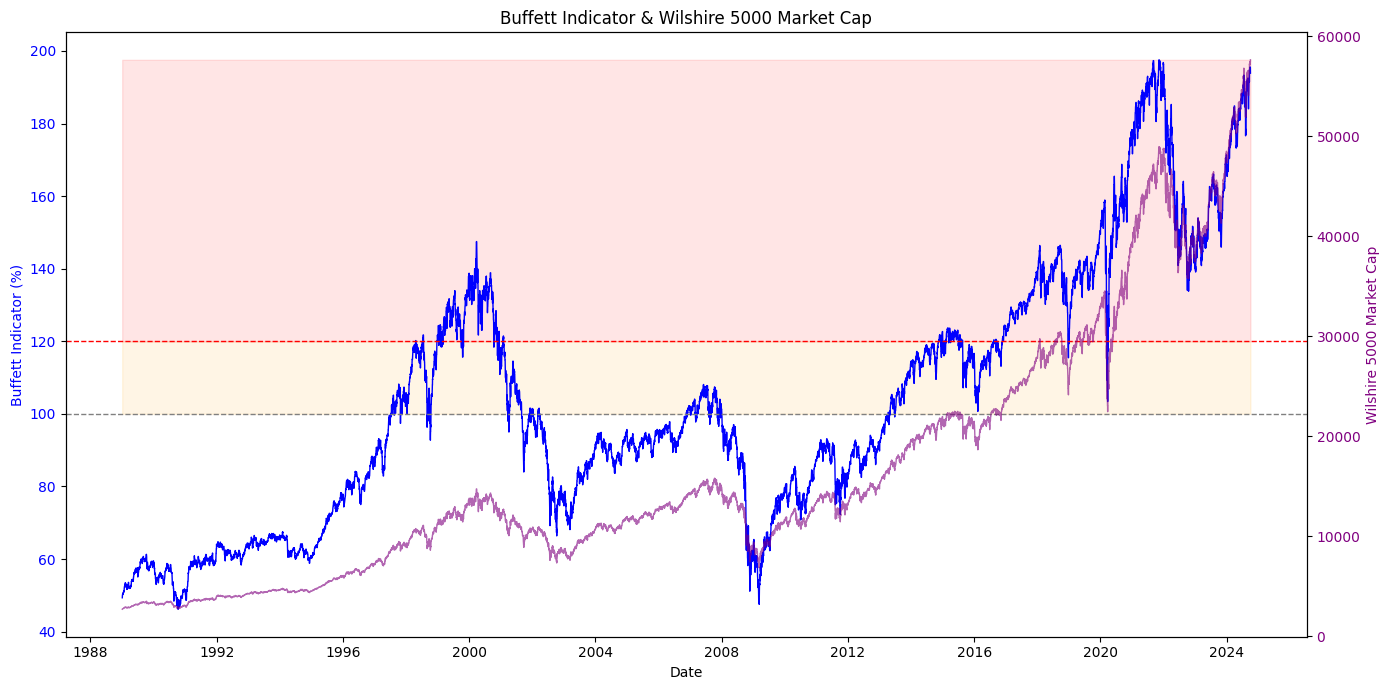

✅ 첫 번째 차트 완료!


In [4]:
# -------------------------------
# 첫 번째 차트: Buffett Indicator + Wilshire 5000
# -------------------------------
print("\n📊 Buffett Indicator + Wilshire 5000 시각화 중...")
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax1.plot(buffett_df['Date'], buffett_df['Buffett_Indicator'], color='blue', linewidth=1, label='Buffett Indicator (%)')
ax1.fill_between(buffett_df['Date'], 100, 120, color='orange', alpha=0.1)
ax1.fill_between(buffett_df['Date'], 120, buffett_df['Buffett_Indicator'].max(), color='red', alpha=0.1)
ax1.axhline(y=100, color='gray', linestyle='--', linewidth=1)
ax1.axhline(y=120, color='red', linestyle='--', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Buffett Indicator (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(buffett_df['Date'], buffett_df['Market_Cap'], color='purple', linewidth=1, alpha=0.6, label='Wilshire 5000 (Market Cap)')
ax2.set_ylabel('Wilshire 5000 Market Cap', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Buffett Indicator & Wilshire 5000 Market Cap')
fig = plt.gcf()
fig.tight_layout()
plt.show()
print("✅ 첫 번째 차트 완료!")


📈 Fear & Greed Index + S&P 500 시각화 중...
🔄 Fear & Greed Index 데이터 범위로 S&P500 데이터 필터링 중...
✅ 병합 완료! 총 1813 행


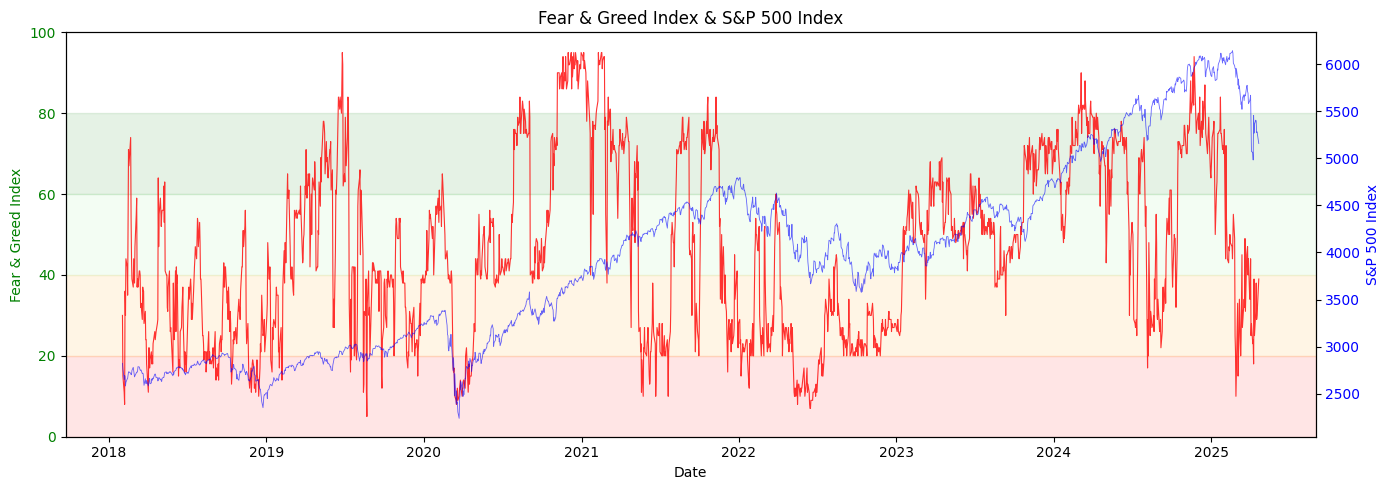

✅ 두 번째 차트 완료!


In [5]:
# -------------------------------
# 두 번째 시트: Fear & Greed Index + S&P 500
# -------------------------------
print("\n📈 Fear & Greed Index + S&P 500 시각화 중...")
# Fear & Greed Index 기간에 맞춰 S&P500 데이터 필터링
print("🔄 Fear & Greed Index 데이터 범위로 S&P500 데이터 필터링 중...")
date_min = fng_df['Date'].min()
date_max = fng_df['Date'].max()
filtered_sp500_df = sp500_df[(sp500_df['Date'] >= date_min) & (sp500_df['Date'] <= date_max)]

merged_sp500 = pd.merge(fng_df, filtered_sp500_df, on='Date', how='inner')
print(f"✅ 병합 완료! 총 {len(merged_sp500)} 행")

plt.figure(figsize=(14, 5))
ax1 = plt.gca()
ax1.plot(merged_sp500['Date'], merged_sp500['FearGreedValue'], color='red', linewidth=0.8, alpha=0.8, label='Fear & Greed Index')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fear & Greed Index', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim(0, 100)  # Fear & Greed Index 범위 고정

# 공포/탐욕 구간 강조
ax1.axhspan(0, 20, color='red', alpha=0.1)
ax1.axhspan(20, 40, color='orange', alpha=0.1)
ax1.axhspan(40, 60, color='lightgreen', alpha=0.1)
ax1.axhspan(60, 80, color='green', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(merged_sp500['Date'], merged_sp500['SP500_Close'], color='blue', linewidth=0.6, alpha=0.6, label='S&P 500 Close')
ax2.set_ylabel('S&P 500 Index', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Fear & Greed Index & S&P 500 Index')
fig = plt.gcf()
fig.tight_layout()
plt.show()

print("✅ 두 번째 차트 완료!")

In [9]:
# -------------------------------
# 4. Streamlit 대시보드 코드 저장 및 실행
# -------------------------------

print("📝 Streamlit 대시보드 코드 작성 중...")
streamlit_dashboard_code = """
import streamlit as st
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

st.set_page_config(page_title="시장 심리 대시보드", layout="wide")
st.title("📈 시장 심리 대시보드: Buffett Indicator & Fear & Greed Index")
st.markdown("미국 시장의 심리적 상태를 두 가지 핵심 지표로 한눈에 파악하세요.")

# DuckDB 연결
con = duckdb.connect(database='buffett_indicator.duckdb', read_only=True)

# Buffett Indicator 데이터 로드
st.subheader("📊 Buffett Indicator & Wilshire 5000 Market Cap")
buffett_df = con.execute("SELECT * FROM buffett_indicator_data").fetchdf()

fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(buffett_df['Date'], buffett_df['Buffett_Indicator'], color='blue', linewidth=1, label='Buffett Indicator (%)')
ax1.fill_between(buffett_df['Date'], 100, 120, color='orange', alpha=0.1)
ax1.fill_between(buffett_df['Date'], 120, buffett_df['Buffett_Indicator'].max(), color='red', alpha=0.1)
ax1.axhline(y=100, color='gray', linestyle='--', linewidth=1)
ax1.axhline(y=120, color='red', linestyle='--', linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Buffett Indicator (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(buffett_df['Date'], buffett_df['Market_Cap'], color='purple', linewidth=1, alpha=0.6, label='Wilshire 5000 Market Cap')
ax2.set_ylabel('Wilshire 5000 Market Cap', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

fig1.tight_layout()
st.pyplot(fig1)

# Fear & Greed Index + S&P500 데이터 로드
st.subheader("📊 Fear & Greed Index & S&P 500 Index")
fng_df = con.execute("SELECT * FROM fear_greed_index_data").fetchdf()
sp500_df = con.execute("SELECT * FROM sp500_data").fetchdf()

# 전처리
fng_df['Date'] = pd.to_datetime(fng_df['Date']).dt.date
sp500_df['Date'] = pd.to_datetime(sp500_df['Date']).dt.date

# 병합
available_dates = fng_df['Date']
filtered_sp500_df = sp500_df[sp500_df['Date'].isin(available_dates)]
merged_sp500 = pd.merge(fng_df, filtered_sp500_df, on='Date', how='inner')

fig2, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(merged_sp500['Date'], merged_sp500['FearGreedValue'], color='green', linewidth=1, alpha=0.6, label='Fear & Greed Index')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fear & Greed Index', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim(0, 100)

# 공포/탐욕 구간 강조
ax1.axhspan(0, 20, color='red', alpha=0.1)
ax1.axhspan(20, 40, color='orange', alpha=0.1)
ax1.axhspan(40, 60, color='lightgreen', alpha=0.1)
ax1.axhspan(60, 100, color='green', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(merged_sp500['Date'], merged_sp500['SP500_Close'], color='orange', linewidth=1, alpha=0.6, label='S&P 500 Close')
ax2.set_ylabel('S&P 500 Index', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig2.tight_layout()
st.pyplot(fig2)

st.success("✅ 대시보드가 성공적으로 로드되었습니다!")
"""

with open("app.py", "w") as file:
    file.write(streamlit_dashboard_code)

print("✅ Streamlit 대시보드 코드 저장 완료!")

📝 Streamlit 대시보드 코드 작성 중...
✅ Streamlit 대시보드 코드 저장 완료!


In [ ]:
# ngrok으로 공개 URL 생성 (Authtoken 필요)
from pyngrok import ngrok

# 아래에 발급받은 ngrok authtoken 입력하세요!
NGROK_AUTH_TOKEN = "2w1lMu0vDS1pgY2wDQ0d4mJ8IyP_2Jim9cP1bo2r65A59DGmo"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

print("[INFO] ngrok 터널 생성 중...")
public_url = ngrok.connect(addr="8501", proto="http")
print(f"[INFO] Streamlit 앱 Public URL: {public_url}")

# Streamlit 앱 실행
!streamlit run app.py --server.port 8501 --server.enableCORS false

print("[INFO] Streamlit 웹 서비스가 실행되었습니다. 위의 Public URL을 클릭하여 접속하세요!")

[INFO] ngrok 터널 생성 중...
[INFO] Streamlit 앱 Public URL: NgrokTunnel: "https://5fa8-34-74-61-85.ngrok-free.app" -> "http://localhost:8501"
2025-04-22 00:48:22.496 
As a result, 'server.enableCORS' is being overridden to 'true'.

More information:
In order to protect against CSRF attacks, we send a cookie with each request.
To do so, we must specify allowable origins, which places a restriction on
cross-origin resource sharing.

If cross origin resource sharing is required, please disable server.enableXsrfProtection.
            



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.74.61.85:8501

